<a href="https://colab.research.google.com/github/ebamberg/research-projects-ml/blob/main/Video_Processing/examples_video_processing_with_SAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#
# When running on Google Colab
#
import torch
import torchvision
import sys
!{sys.executable} -m pip install opencv-python matplotlib --quiet
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git' --quiet
# triton is used for compilation of the model
!{sys.executable} -m pip install triton --quiet

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_small.pt

!wget -P ./ https://raw.githubusercontent.com/facebookresearch/sam2/refs/heads/main/sam2/configs/sam2.1/sam2.1_hiera_l.yaml
!wget -P ./ https://raw.githubusercontent.com/facebookresearch/sam2/refs/heads/main/sam2/configs/sam2.1/sam2.1_hiera_s.yaml

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.9 MB/s eta 0:00:00
--2024-11-20 17:57:29--  https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.68, 3.171.22.33, 3.171.22.118, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 898083611 (856M) [application/vnd.snesdev-page-table]
Saving to: ‘../checkpoints/sam2.1_hiera_large.pt’



In [2]:
!mkdir -p videos
!wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
!unzip -d videos videos/bedroom.zip
# extract frames from videos
# !ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 videos/'%05d.jpg'


--2024-11-20 17:57:37--  https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.68, 3.171.22.33, 3.171.22.118, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12688166 (12M) [application/zip]
Saving to: ‘videos/bedroom.zip’

bedroom.zip         100%[===================>]  12.10M  --.-KB/s    in 0.1s    

2024-11-20 17:57:37 (88.0 MB/s) - ‘videos/bedroom.zip’ saved [12688166/12688166]

Archive:  videos/bedroom.zip
   creating: videos/bedroom/
  inflating: videos/bedroom/00005.jpg  
  inflating: videos/bedroom/00121.jpg  
  inflating: videos/bedroom/00079.jpg  
  inflating: videos/bedroom/00126.jpg  
  inflating: videos/bedroom/00002.jpg  
  inflating: videos/bedroom/00128.jpg  
  inflating: videos/bedroom/00070.jpg  
  inflating: videos/bedroom/00185.jpg  
  inflating: videos/bedroom/00154.jpg  
  infl

In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True



In [4]:
from sam2.build_sam import build_sam2_video_predictor
from sam2.sam2_image_predictor import SAM2ImagePredictor

#sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
#model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_checkpoint = "../checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

# set compile flag for better performance in cofg file model_cfg.compile_image_encoder=True
overrides = [ 'model.compile_image_encoder=true']
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device, hydra_overrides_extra=overrides)


Image encoder compilation is enabled. First forward pass will be slow.


In [5]:

def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

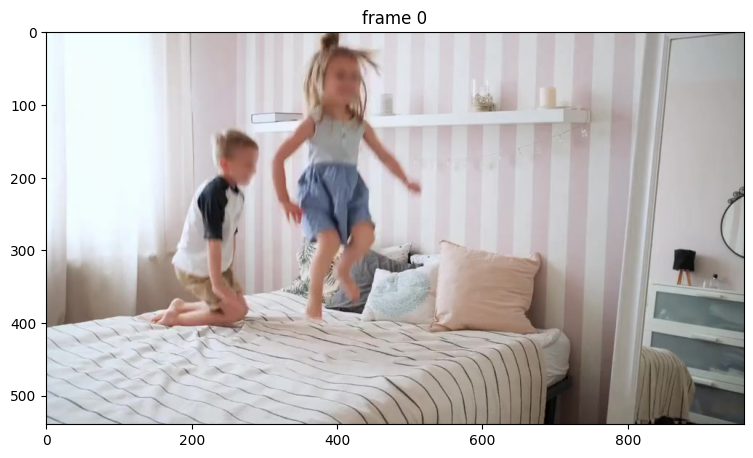

In [6]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/bedroom"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [7]:
#  create interference state => scans all frames
inference_state = predictor.init_state(video_path=video_dir)


frame loading (JPEG): 100%|██████████| 200/200 [00:06<00:00, 32.89it/s]


/usr/local/lib/python3.10/dist-packages/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/usr/local/lib/python3.10/dist-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


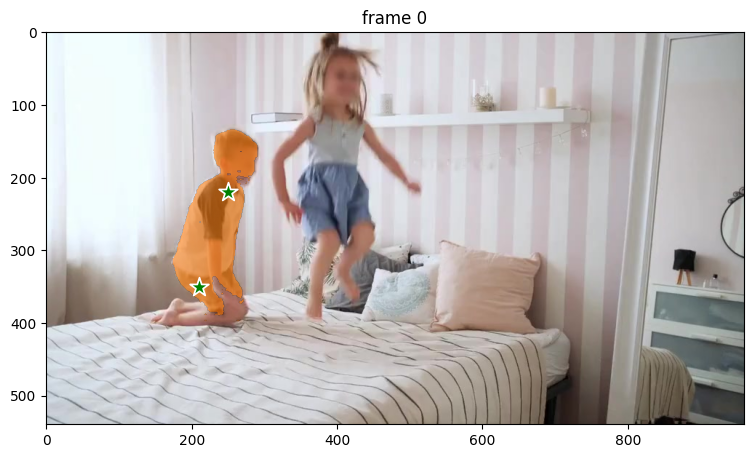

In [8]:
predictor.reset_state(inference_state)

start_frame_idx = 0  # the frame index we interact with
obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# Let's add a positive click at (x, y) = (210, 350) to get started
points = np.array([[210, 350], [250, 220]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1,1], np.int32)

_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=start_frame_idx,
    obj_id=obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
plt.figure(figsize=(9, 6))
plt.title(f"frame {start_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[start_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

OK now we can propagate the mask through the whole video

In [ ]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

propagate in video:   0%|          | 0/200 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/usr/local/lib/python3.10/dist-packages/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video:  30%|██▉       | 59/200 [01:59<04:06,  1.75s/it]